In [1]:
import time
from time import perf_counter

# Data processing.
import json
import numpy as np
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
%matplotlib notebook

# "Vanilla" python parallelism.
import multiprocessing

# Scalable data analytics: dask.
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import graphviz

# For GC large pandas dataframes after use.
import gc

# Ignore warnings.
import warnings
warnings.simplefilter("ignore")

# Load Data

In [2]:
# This lazily creates a timeseries dataset for us with around 7.6M rows.
dd_df = dd.demo.make_timeseries(start='2018-01-01',
                                end='2018-03-30',
                                dtypes={'x': float, 'y': float, 'id': int},
                                freq='1s',
                                partition_freq='24h')

dd_df

,id,x,y
npartitions=88,,,
2018-01-01,int64,float64,float64
2018-01-02,...,...,...
...,...,...,...
2018-03-29,...,...,...
2018-03-30,...,...,...


In [3]:
dd_df.head()

,id,x,y
timestamp,,,
2018-01-01 00:00:00,1015,0.208634,-0.263514
2018-01-01 00:00:01,1005,-0.327202,0.694140
2018-01-01 00:00:02,987,0.377936,-0.069441
2018-01-01 00:00:03,1003,0.143366,0.796446
2018-01-01 00:00:04,1044,0.583137,0.412662


# Start Client

In [4]:
n_cores = multiprocessing.cpu_count()
print('number of cores: ', n_cores)

number of cores:  4


In [5]:
cluster = LocalCluster(ip=None, n_workers=n_cores, processes=True)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:40475 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.14 GB


# Q2

In [14]:
runtime_df = pd.DataFrame(columns=['n_cores','runtime (ms)'])

n_workers = 1
while n_workers <= n_cores:
    print('Resizing cluster to %s worker(s)...' % n_workers)
    cluster.scale(n_workers)
    time.sleep(1)
    
    t_start = perf_counter()
    dd_df.y.rolling('5min').mean().loc['2018-01-01':'2018-01-31'].compute()
    t_stop = perf_counter()
    
    runtime = (t_stop - t_start)*1000
    runtime_df = runtime_df.append({'n_cores': n_workers,'runtime (ms)': runtime},ignore_index=True)
    print('dask time (ms): ', runtime)
    n_workers *= 2;

Resizing cluster to 1 worker(s)...
dask time (ms):  2525.1510000016424
Resizing cluster to 2 worker(s)...
dask time (ms):  2887.740099999064
Resizing cluster to 4 worker(s)...
dask time (ms):  2937.811199997668


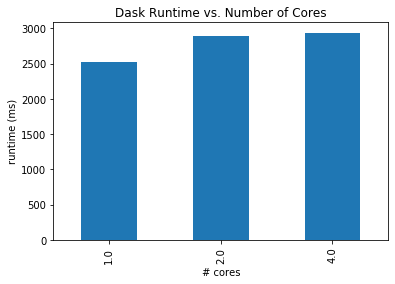

In [15]:
runtime_df.plot(x='n_cores',y='runtime (ms)',kind='bar',legend=False)
plt.title('Dask Runtime vs. Number of Cores')
plt.xlabel('# cores')
plt.ylabel('runtime (ms)')
plt.savefig('images/q2.png')

In [24]:
t_1 = perf_counter()
df = dd_df.compute()
t_2 = perf_counter()
df.y.rolling('5min').mean().loc['2018-01-01':'2018-01-31']
t_3 = perf_counter()
print('Pandas time for computation only(ms): %s' % ((t_3 - t_2)*1000))
print('Pandas time with table conversion (ms): %s' % ((t_3 - t_1)*1000))


# GC pandas df.
del df
gc.collect()

Pandas time for computation only(ms): 641.5956000018923
Pandas time with table conversion (ms): 2776.6767000030086


2049

In [26]:
df = dd_df.compute()
df.y.rolling('5min').mean().loc['2018-01-01':'2018-01-31']

timestamp
2018-01-01 00:00:00   -0.263514
2018-01-01 00:00:01    0.215313
2018-01-01 00:00:02    0.120395
2018-01-01 00:00:03    0.289408
2018-01-01 00:00:04    0.314059
                         ...   
2018-01-31 23:59:55   -0.027162
2018-01-31 23:59:56   -0.028964
2018-01-31 23:59:57   -0.026947
2018-01-31 23:59:58   -0.020739
2018-01-31 23:59:59   -0.017693
Freq: S, Name: y, Length: 2678400, dtype: float64


# Q3

In [10]:
urls = (db.read_text('https://archive.analytics.mybinder.org/index.jsonl')
                    .map(json.loads)
                    .pluck('name')
                    .compute())
urls = ['https://archive.analytics.mybinder.org/' + u for u in urls]
notebook_runs = db.read_text(urls).map(json.loads)

In [12]:
runtime_df_q3 = pd.DataFrame(columns=['n_cores','runtime (ms)'])

n_workers = 1
while n_workers <= n_cores:
    print('Resizing cluster to %s worker(s)...' % n_workers)
    cluster.scale(n_workers)
    time.sleep(1)
    
    t_start = perf_counter()
    (notebook_runs.filter(lambda record: record['timestamp'].startswith('2019-08'))
                 .pluck('provider').frequencies(sort=True).take(2))
    t_stop = perf_counter()
    
    runtime = (t_stop - t_start)*1000
    runtime_df_q3 = runtime_df_q3.append({'n_cores': n_workers,'runtime (ms)': runtime},ignore_index=True)
    print('dask time (ms): ', runtime)
    n_workers *= 2

Resizing cluster to 1 worker(s)...
dask time (ms):  249008.9795999993
Resizing cluster to 2 worker(s)...
dask time (ms):  153375.6652000011
Resizing cluster to 4 worker(s)...
dask time (ms):  102789.95629999918


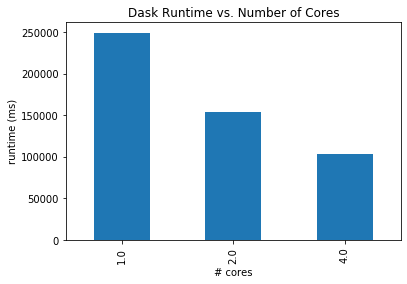

In [13]:
runtime_df_q3.plot(x='n_cores',y='runtime (ms)',kind='bar',legend=False)
plt.title('Dask Runtime vs. Number of Cores')
plt.xlabel('# cores')
plt.ylabel('runtime (ms)')
plt.savefig('images/q3.png')

In [11]:
notebook_runs.filter(lambda record: record['timestamp'].startswith('2019-08')).pluck('provider').frequencies(sort=True).take(2)

(('GitHub', 374145), ('Gist', 5894))